In [73]:
!pip install --upgrade --quiet google-genai ipytest

In [75]:
import datetime

import pandas as pd
from inspect import cleandoc
from IPython.display import display, Markdown
import ipytest
import pytest
from unittest.mock import MagicMock

import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
from vertexai.evaluation import (
    MetricPromptTemplateExamples,
    EvalTask,
    PairwiseMetric,
    PairwiseMetricPromptTemplate,
    PointwiseMetric,
    PointwiseMetricPromptTemplate,
)
PROJECT_ID='qwiklabs-gcp-03-5e74bd2ddda2'
LOCATION='us-central1'
vertexai.init(project=PROJECT_ID, location=LOCATION)

ipytest.autoconfig()


In [78]:
CAT_PROMPT = """Categorize the prompt below into one of the following categories: Employment, General Information, Emergency Services, Tax Related. Respond with only the category name.

<prompt>{prompt}</prompt>"""
CAT_TASKS = [
    "What is the tax refund process?",
    "How do I apply for a job?",
    "What is the number for 911?",
    "Is my fireman's pension reportable as income?"
]
CAT_PROMPTS = [CAT_PROMPT.format(prompt=task) for task in CAT_TASKS]
CAT_CATS = ["Tax Related", "Employment", "Emergency Services", "Tax Related"]
CAT_MODEL = GenerativeModel("gemini-2.5-flash",generation_config={"temperature":0})
def categorize(prompt, template=CAT_PROMPT):
    llm_pro = CAT_MODEL
    content = llm_pro.generate_content(CAT_PROMPT.format(prompt=prompt))
    return content.text
#integration-style unit test. I know it's a bit dodgy for unit tests to call the model,
#but I implement a unit test with mocks for my other function below to demonstrate I can do that
def test_categorize():
    """make sure the categorize function returns the expected values

    since this test calls the model, I am limiting it to a single call.
    The first evaluation will perform a more thorough test of the model"""
    assert categorize("What is the number for 911?") == "Emergency Services"


In [4]:
display(Markdown(categorize("What is the tax refund process?")))

Tax Related

In [5]:
display(Markdown(categorize("Is my fireman's pension reportable as income?")))

Tax Related

In [6]:
test_categorize()

### Evaluating the categorization model

Run an evaluation and use bleu/exact match metrics to confirm that the model's response matches expected values

In [68]:
from vertexai import Client
client= Client(project=PROJECT_ID, location=LOCATION)
prompts_df = pd.DataFrame({"prompt": CAT_PROMPTS, "reference": CAT_CATS})
cat_eval_dataset = client.evals.run_inference(model="gemini-2.5-flash", src=prompts_df)


Gemini Inference: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


In [69]:
display(cat_eval_dataset)

EvaluationDataset(
  candidate_name='gemini-2.5-flash',
  eval_dataset_df=                                                                                                                                                                                                                                       prompt  \
    0                Categorize the prompt below into one of the following categories: Employment, General Information, Emergency Services, Tax Related. Respond with only the category name.\n\n<prompt>What is the tax refund process?</prompt>   
    1                      Categorize the prompt below into one of the following categories: Employment, General Information, Emergency Services, Tax Related. Respond with only the category name.\n\n<prompt>How do I apply for a job?</prompt>   
    2                    Categorize the prompt below into one of the following categories: Employment, General Information, Emergency Services, Tax Related. Respond with only the category name.\n

In [70]:
from vertexai import types
cat_eval_result = client.evals.evaluate(
    dataset=cat_eval_dataset,
    metrics=[
        types.Metric(name='bleu'),
        types.Metric(name='exact_match')
    ],
)

Computing Metrics for Evaluation Dataset: 100%|██████████| 8/8 [00:00<00:00, 74.12it/s]


In [71]:
display(cat_eval_result.summary_metrics)

[AggregatedMetricResult(
   mean_score=0.0,
   metric_name='bleu',
   num_cases_error=0,
   num_cases_total=4,
   num_cases_valid=4,
   stdev_score=0.0
 ),
 AggregatedMetricResult(
   mean_score=1.0,
   metric_name='exact_match',
   num_cases_error=0,
   num_cases_total=4,
   num_cases_valid=4,
   stdev_score=0.0
 )]

##Social media post model

2 different prompts are defined. We will run pairwise evaluations to determine which prompt produces better coherence/fluency.

In [39]:
SOCIAL_PROMPT = """You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options

<announcement>{prompt}</announcement>"""
SOCIAL_PROMPT_2 = """Summary: {prompt}
Social Media Post (single post; no options):"""
SOCIAL_TASKS = [
    "Annual Arbor Day parade next Wednesday. It may rain, but the parade will still be on.",
    "Sheriff Kling is hosting a 10th birthday party for his cat, Fluffers. Gifts encouraged.",
    "Main St. will be closed for construction tomorrow."
 ]
SOCIAL_MODEL = GenerativeModel("gemini-2.5-flash",generation_config={"temperature":0.8})
def social_post(prompt, template=SOCIAL_PROMPT):
    content = SOCIAL_MODEL.generate_content(template.format(prompt=prompt))
    return content.text

In [76]:
# prompt: write a pytest test for the social_post function. SOCIAL_MODEL should be mocked out

import pytest
from unittest.mock import MagicMock

# Mock the GenerativeModel and its generate_content method
mock_generate_content = MagicMock()
mock_generate_content.return_value.text = "Mocked social media post"
SOCIAL_MODEL.generate_content = mock_generate_content

def test_social_post():
    """Tests the social_post function with a mocked model."""
    prompt = "Test announcement"
    expected_output = "Mocked social media post"

    result = social_post(prompt)

    # Assert that the model's generate_content was called with the correct prompt
    mock_generate_content.assert_called_once_with(SOCIAL_PROMPT.format(prompt=prompt))

    # Assert that the function returns the mocked output
    assert result == expected_output


In [37]:
display(Markdown(social_post(SOCIAL_TASKS[0], SOCIAL_PROMPT)))

🌿 Get ready to celebrate our town's green spirit! Our Annual Arbor Day Parade is marching into town next Wednesday! 🌳

We're keeping an eye on the forecast, but come rain or shine, the parade *will* go on! So, grab your umbrellas just in case, and join us for a wonderful community celebration. We can't wait to see you there!

#ArborDayParade #TownCelebration #CommunityLove #RainOrShine

In [40]:
display(Markdown(social_post(SOCIAL_TASKS[0], SOCIAL_PROMPT_2)))

Get ready to celebrate! 🎉 Our Annual Arbor Day Parade is happening next Wednesday! 🌳

We know there's a chance of rain 🌧️, but don't worry – the parade is still a GO! We'll be marching on, rain or shine, to honor our beautiful trees and community.

Grab your umbrellas if needed, and come join the fun! See you there!

#ArborDay #Parade #CommunityEvent #RainOrShine #TreeLove

### Evaluating the social model

Here the responses using two different prompts are compared, and gemini is leveraged to judge which prompt produces results with better coherence/fluency

You may have noticed that in my prompts, I explicitly ask for a single post rather than multiple options. The evaluation was penalizing responses that returned multiple options, so I added these instructions to both prompts to provide a fairer apples-to-apples comparison

In [41]:
eval_dataset = pd.DataFrame({"prompt": [SOCIAL_PROMPT.format(prompt=task) for task in SOCIAL_TASKS]})
display(eval_dataset["prompt"])


,prompt
0,"You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options\n\n<announcement>Annual Arbor Day parade next Wednesday. It may rain, but the parade will still be on.</announcement>"
1,"You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options\n\n<announcement>Sheriff Kling is hosting a 10th birthday party for his cat, Fluffers. Gifts encouraged.</announcement>"
2,You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options\n\n<announcement>Main St. will be closed for construction tomorrow.</announcement>


In [42]:
eval_dataset["baseline_model_response"] = eval_dataset["prompt"].map(lambda task:SOCIAL_MODEL.generate_content(SOCIAL_PROMPT_2.format(prompt=task)).text)

In [43]:
display(eval_dataset)

,prompt,baseline_model_response
0,"You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options\n\n<announcement>Annual Arbor Day parade next Wednesday. It may rain, but the parade will still be on.</announcement>",🌳 Get ready to *leaf* your worries behind! Our Annual Arbor Day Parade is marching into town next Wednesday! Join us for a tree-mendous celebration of nature and community spirit. And don't worry about those April showers – this parade is happening rain or shine! See you there! #ArborDay #TownCelebration #ParadeDay #CommunityLove
1,"You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options\n\n<announcement>Sheriff Kling is hosting a 10th birthday party for his cat, Fluffers. Gifts encouraged.</announcement>","Get ready to paw-ty! 🎉 Our very own Sheriff Kling is throwing a purr-fectly delightful 10th birthday bash for his beloved feline companion, Fluffers! Join us in celebrating a decade of purrs, playful antics, and community spirit. While your friendly faces are the greatest gift, a little something for the birthday cat would surely make Fluffers' day extra special! 😉 Stay tuned for party details! #FluffersTurns10 #SheriffKling #CommunityCelebration #CatsofOurTown"
2,You are the town's social media manager. Write a social media post for the announcement below. The tone should be fun but professional. Do not provide multiple options\n\n<announcement>Main St. will be closed for construction tomorrow.</announcement>,"Heads up, Anytown! 👋 Get ready for a little detour tomorrow as Main Street will be closed for essential construction work. We're sprucing things up to make our town even better! Please plan alternative routes for your travels. Your patience and understanding are always appreciated as we work to improve our community! #TownImprovements #MainStreetUpdate"


In [44]:
eval_task = EvalTask(
  dataset=eval_dataset,
  metrics=[MetricPromptTemplateExamples.Pairwise.COHERENCE, MetricPromptTemplateExamples.Pairwise.FLUENCY],
  experiment="social-coherence-fluency",
  output_uri_prefix="gs://mattboehm-genai",
)

result = eval_task.evaluate(model=CAT_MODEL, experiment_run_name="social-coherence-fluency-"+datetime.datetime.now().strftime("%Y%m%d%H%M%S"))

INFO:vertexai.evaluation.eval_task:Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-2.5-flash', 'temperature': 0, 'output_file': 'gs://mattboehm-genai/eval_results_2025-12-05-16-54-51-1d98a.csv'}
INFO:vertexai.evaluation._evaluation:Generating a total of 3 responses from Gemini model gemini-2.5-flash.
100%|██████████| 3/3 [00:08<00:00,  2.92s/it]
INFO:vertexai.evaluation._evaluation:All 3 responses are successfully generated from Gemini model gemini-2.5-flash.
INFO:vertexai.evaluation._evaluation:Multithreaded Batch Inference took: 8.757119324000087 seconds.
INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 6 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 6/6 [00:11<00:00,  1.89s/it]
INFO:vertexai.evaluation._evaluation:All 6 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:11.335515262999706 seconds


In [31]:
display(result.summary_metrics)

{'row_count': 3,
 'pairwise_coherence/candidate_model_win_rate': np.float64(0.3333333333333333),
 'pairwise_coherence/baseline_model_win_rate': np.float64(0.6666666666666666),
 'pairwise_fluency/candidate_model_win_rate': np.float64(0.0),
 'pairwise_fluency/baseline_model_win_rate': np.float64(0.6666666666666666)}

In [32]:
display(result.metrics_table)

,prompt,baseline_model_response,response,pairwise_coherence/explanation,pairwise_coherence/pairwise_choice,pairwise_fluency/explanation,pairwise_fluency/pairwise_choice
0,You are the town's social media manager. Write...,"Here are a few options, choose the one that be...","Here are a few options, pick the one that best...",Both responses are excellent and provide multi...,CANDIDATE,Both BASELINE response and CANDIDATE response ...,TIE
1,You are the town's social media manager. Write...,🎉 Get ready for a *purr-fectly* wonderful cele...,"Here are a few options, pick the one that best...",BASELINE response directly answers the prompt ...,BASELINE,"BASELINE response provides a single, cohesive ...",BASELINE
2,You are the town's social media manager. Write...,"Heads up, [Your Town Name]! 🚧 Important announ...","Here are a few options, pick the one that best...",BASELINE response directly provides a single s...,BASELINE,BASELINE response fully embodies the persona o...,BASELINE


In [45]:
pd.set_option('display.max_colwidth', None)
display(result.metrics_table[['pairwise_coherence/pairwise_choice', 'pairwise_coherence/explanation', 'pairwise_fluency/pairwise_choice', 'pairwise_fluency/explanation']])

,pairwise_coherence/pairwise_choice,pairwise_coherence/explanation,pairwise_fluency/pairwise_choice,pairwise_fluency/explanation
0,CANDIDATE,"Both responses are excellent and adhere to all instructions. CANDIDATE response is slightly better because its suggestion to 'grab your rain gear and your biggest smiles' adds a proactive and even more engaging touch to the 'fun but professional' tone when addressing the potential rain, making it feel a little more complete and actionable for the audience.",TIE,"Both responses exhibit excellent fluency, with no grammatical errors, varied sentence structures appropriate for a social media post, and a consistent, natural flow that blends fun and professional tones seamlessly. Neither response is discernibly superior to the other in terms of language mastery."
1,BASELINE,"Both responses are excellent and fulfill the prompt requirements. BASELINE response slightly edges out CANDIDATE response due to its more nuanced and charming way of encouraging gifts (""While your friendly faces are the greatest gift, a little something for the birthday cat would surely make Fluffers' day extra special! 😉""), which perfectly balances the 'fun but professional' tone. BASELINE response also subtly integrates 'community spirit,' adding a professional touch, and its hashtags are a bit more creative.",BASELINE,"Both responses are excellent in terms of fluency, demonstrating strong grammar, varied sentence structures, and consistent tone. However, BASELINE response has a slight edge due to its more seamless integration of the 'gifts encouraged' request, phrasing it in a nuanced and charming way that maintains the fun, professional tone without being overly direct, contributing to a marginally smoother and more engaging flow overall."
2,BASELINE,"Both responses are excellent and follow the instructions well, maintaining a fun but professional tone. BASELINE response is marginally better as its phrasing, 'Get ready for a little detour tomorrow as Main Street will be closed for essential construction work. We're sprucing things up to make our town even better!', creates a slightly more coherent and engaging narrative by immediately connecting the inconvenience with the positive outcome, and its closing also feels a touch more comprehensive.",TIE,"Both BASELINE response and CANDIDATE response demonstrate excellent fluency, with perfect grammar, varied sentence structures appropriate for a social media post, consistent fun but professional tones, and a natural, seamless flow that is easy to understand. Neither response exhibits any significant flaws in fluency that would make one superior to the other."


###Evaluation Results from Colab Enterprise Sidebar

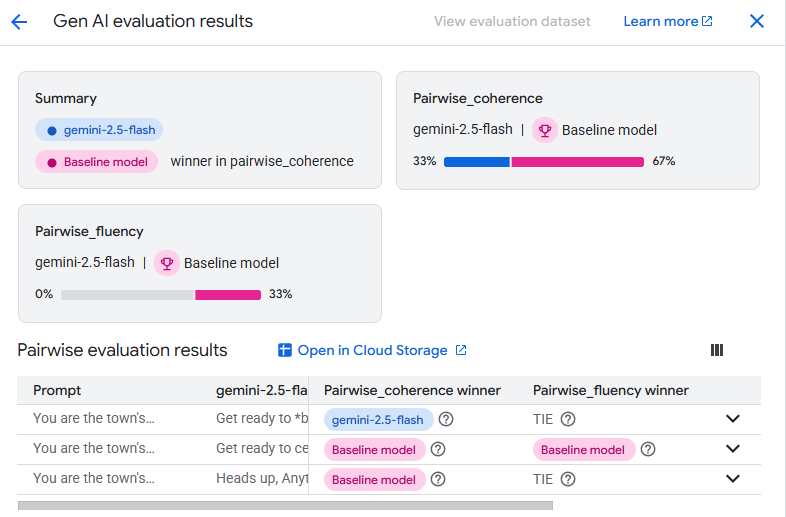

Run all unit tests

In [77]:
ipytest.run()

..                                                                                           [100%]
========================================= warnings summary =========================================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
2 passed, 1 warning in 3.77s


<ExitCode.OK: 0>